In [1]:
import re
import sqlalchemy as sa
import sqlalchemy.ext.hybrid
import sqlalchemy.ext.declarative as sa_dec
import sqlalchemy_searchable as searchable

from web import models as m
from web.models import *

In [2]:
engine = sa.create_engine('postgresql+psycopg2://root:@localhost/tm_navigator', echo=0)
sa.orm.configure_mappers()

In [106]:
Base.metadata.create_all(engine)

In [104]:
Base.metadata.drop_all(engine)

In [105]:
conn = engine.raw_connection()
with conn.cursor() as cursor:
    cursor.execute('''
    select tablename
    from pg_tables
    where schemaname = 'public';
    ''')
    tables = [r[0] for r in cursor.fetchall()]
    print('\n'.join(tables))
    if raw_input() == 'y':
        for t in tables:
            print('drop table "%s" cascade;' % t)
            cursor.execute('drop table "%s" cascade' % t)
    cursor.execute('commit')

Couldn't import dot_parser, loading of dot files will not be possible.


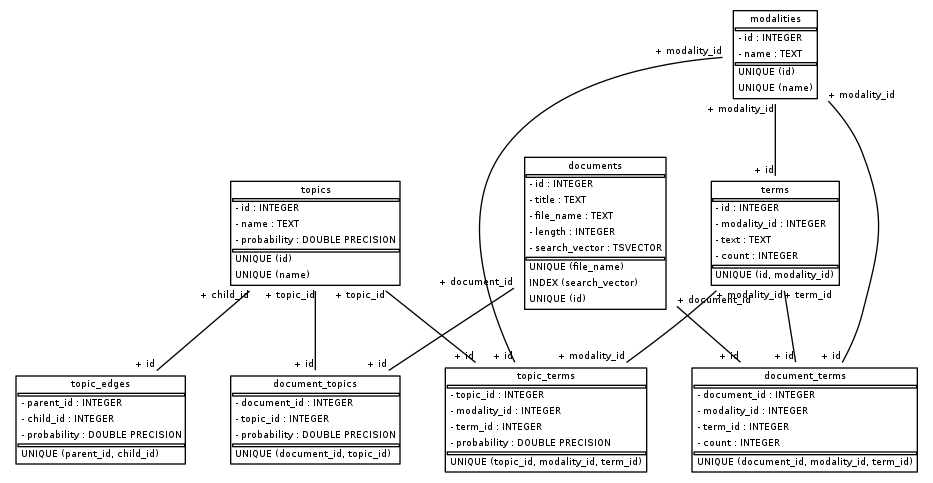

In [4]:
from sqlalchemy_schemadisplay import create_schema_graph
from IPython.display import display, Image

# create the pydot graph object by autoloading all tables via a bound metadata object
graph = create_schema_graph(metadata=sa.MetaData('postgresql+psycopg2://root:@localhost/tm_navigator'))
graph.write_png('dbschema.png') # write out the file

display(Image(filename='dbschema.png'))

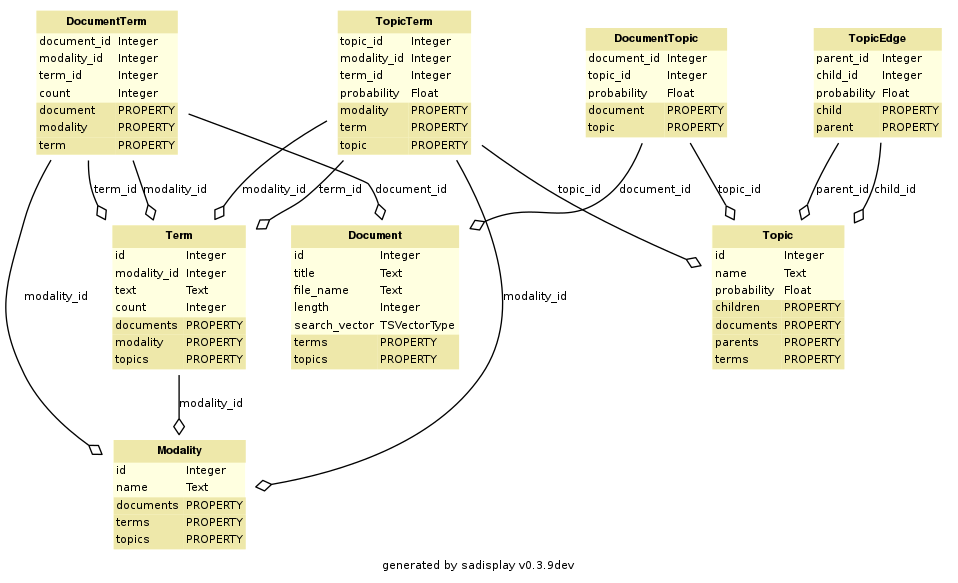

In [5]:
import sadisplay
from IPython.display import display, Image

classes = [c
           for c in m.Base._decl_class_registry.values()
           if 'Dummy' not in getattr(c, '__name__', 'Dummy')]
desc = sadisplay.describe(classes)
open('dbschema.dot', 'w').write(sadisplay.dot(desc))
!dot -Tpng dbschema.dot > dbschema.png

display(Image(filename='dbschema.png'))

In [3]:
Session = sa.orm.sessionmaker(bind=engine)

In [4]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""
    session = Session()
    try:
        yield session
        session.commit()
    except:
        session.rollback()
        raise
    finally:
        session.close()

In [109]:
import csv
from cStringIO import StringIO
from contextlib import closing

def copy_to_table(session, model, fieldnames, rows):
    with closing(StringIO()) as csv_f:
        writer = csv.DictWriter(csv_f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)
        csv_f.seek(0)

        with session.connection().connection.cursor() as cursor:
            cursor.copy_expert('copy %s (%s) from stdin with csv header' % (model.__tablename__, ', '.join(fieldnames)), csv_f)

In [110]:
with session_scope() as session:
    session.add(Modality(name='words'))

In [111]:
with open('nadya_data/dict.txt') as f, session_scope() as session:
    m_id = session.query(Modality.id).filter(Modality.name == 'words').scalar()
    rows = (dict(id=i, modality_id=m_id, text=line.strip(), count=0)
            for i, line in enumerate(f))
    copy_to_table(session, Term, ['id', 'modality_id', 'text', 'count'], rows)
    
    print session.query(Term).count()

42682


In [112]:
with open('nadya_data/mmro_pdfs/pdfnames.txt') as f:
    fnames = [(int(i), fname)
        for i, fname in (re.match(r'(\d+)\|([\w_/,-]+)\.pdf', line).groups()
                         for line in f)
    ]

with open('nadya_data/mmro_pdfs/titles.txt') as f:
    titles = [(int(i), authors.strip(), title.strip()) for i, authors, title in zip(f, f, f)]
    
assert len(fnames) == len(titles)
assert all(f[0] == t[0] for f, t in zip(fnames, titles))

In [113]:
with session_scope() as session:
    rows = (
        dict(id=f[0], title=t[2], file_name=f[1], length=0)
        for f, t in zip(fnames, titles)
    )
    copy_to_table(session, Document, ['id', 'title', 'file_name', 'length'], rows)
    
    print session.query(Document).count()

865


In [114]:
with session_scope() as session:
    session.add(Modality(name='authors'))

In [115]:
%%time
with session_scope() as session:
    m = session.query(Modality).filter(Modality.name == 'authors').one()
    
    doc_authors = [(i, author.strip())
     for i, authors, title in titles
     for author in authors.split(',')
    ]
    authors = {a for d, a in doc_authors}
    authors_terms = {a: Term(modality=m, text=a, count=0)
                     for a in authors}
    session.add_all(
        DocumentTerm(document_id=d, term=authors_terms[a], count=1)
        for d, a in doc_authors)

CPU times: user 1.48 s, sys: 124 ms, total: 1.6 s
Wall time: 2.49 s


In [116]:
%%time
with session_scope() as session:
    m_id = session.query(Modality.id).filter(Modality.name == 'words').scalar()
    
    with open('nadya_data/ndw.txt') as f:
        D = int(f.readline())
        W = int(f.readline())
        NNZ = int(f.readline())
        print D, W, NNZ
        dwn = (map(int, line.split()) for line in f)
        rows = (dict(document_id=d, modality_id=m_id, term_id=w, count=n)
                for d, w, n in dwn)

        copy_to_table(session, DocumentTerm, ['document_id', 'modality_id', 'term_id', 'count'], rows)
    
    print session.query(DocumentTerm.modality_id, sa.func.count()).group_by(DocumentTerm.modality_id).all()

865 42683 -1
[(1, 190079L), (2, 1892L)]
CPU times: user 1.5 s, sys: 4 ms, total: 1.5 s
Wall time: 9.76 s


In [117]:
import pickle

with open('nadya_data/3level_2907_alt_levels_dict.dump') as f:
    matrices = pickle.loads(f.read().replace('\r\n', '\n'))

In [118]:
%%time
from itertools import izip as zip

with session_scope() as session:
    m_id = session.query(Modality.id).filter(Modality.name == 'words').scalar()
    
    session.add(Topic(id=0, probability=0))

    for (level, mat_name), matrix in sorted(matrices.items()):
        matrix = matrix.tocoo()
        t_to_id = lambda t: (level + 1) * 1000 + t
        
        if mat_name == 'phi':
            copy_to_table(session, Topic, ['id', 'probability'],
                          (dict(id=t_to_id(t), probability=0)
                           for t in range(matrix.shape[1])
                          ))

            rows = [dict(topic_id=t_to_id(int(t)), modality_id=m_id, term_id=int(w), probability=float(val))
                    for w, t, val in zip(matrix.row, matrix.col, matrix.data)]
            copy_to_table(session, TopicTerm, ['topic_id', 'modality_id', 'term_id', 'probability'], rows)
        elif mat_name == 'theta':
            rows = [dict(topic_id=t_to_id(int(t)), document_id=int(d), probability=float(val))
                    for t, d, val in zip(matrix.row, matrix.col, matrix.data)]
            copy_to_table(session, DocumentTopic, ['topic_id', 'document_id', 'probability'], rows)
        else:
            raise
            
    
    print session.query(Topic.level, sa.func.count()).group_by(Topic.level).all()
    print session.query(Topic.level, sa.func.count()).join(DocumentTopic).group_by(Topic.level).all()
    print session.query(Topic.level, sa.func.count()).join(TopicTerm).group_by(Topic.level).all()

[(0, 1L), (2, 32L), (1, 11L), (3, 62L)]
[(2, 3429L), (1, 9335L), (3, 3247L)]
[(2, 79821L), (1, 85221L), (3, 74167L)]
CPU times: user 2.18 s, sys: 40 ms, total: 2.22 s
Wall time: 13.1 s


In [119]:
id_from_nadya = lambda s: sum(mul * int(val)
                              for mul, val in zip([1000, 1], re.findall('\d+', s)))

with session_scope() as session, \
     open('nadya_data/alt2907_3levels_hierarchy_edges.csv') as f:
    reader = csv.DictReader(f, fieldnames=['parent', 'child', 'probability'], delimiter=';')
    edges = ({'parent_id': id_from_nadya(row['parent']),
              'child_id': id_from_nadya(row['child']),
              'probability': float(row['probability'])}
             for row in reader)

    copy_to_table(session, TopicEdge, ['parent_id', 'child_id', 'probability'], edges)

In [120]:
with session_scope() as session:
    session.query(Document).\
        update({Document.length:
                session.query(sa.func.sum(DocumentTerm.count)).join(Modality).\
                filter(DocumentTerm.document_id == Document.id).filter(Modality.name == 'words').
                subquery().as_scalar()},
               synchronize_session=False)
#     counts = session.query(DocumentTerm.document_id, sa.func.sum(DocumentTerm.count).label('sum')).join(Modality)\
#         .filter(Modality.name == 'words').group_by(DocumentTerm.document_id)\
#         .subquery()
#     print session.query(Document).update({Document.length: counts.c.sum})

#     print session.query(Document.length == sa.func.sum(DocumentTerm.count)).join(DocumentTerm).join(Modality).\
#         filter(Modality.name == 'words').group_by(Document).all()

In [121]:
with session_scope() as session:
#     session.query(Term).\
#         update({Term.count:
#                 session.query(sa.sql.functions.coalesce(sa.func.sum(DocumentTerm.count), 0)).\
#                 filter_by(term_id=Term.id, modality_id=Term.modality_id).\
#                 subquery().as_scalar()},
#                synchronize_session=False)
    session.execute('''
    with counts as (
        select modality_id, term_id, sum(count)
        from document_terms
        group by modality_id, term_id
    )
    
    update terms
    set count = counts.sum
    from counts
    where counts.term_id = terms.id and counts.modality_id = terms.modality_id
    ''')
#     print session.query(Term.count == sa.func.sum(DocumentTerm.count)).join(DocumentTerm).group_by(Term).all()

In [122]:
with session_scope() as session:
    session.execute('''
    with docprobs as (
        select id, length::float / sum(length) over () as probability
        from documents
    ), probs as (
        select topic_id, sum(dt.probability * dp.probability) as probability
        from document_topics as dt
        join docprobs as dp on dt.document_id = dp.id
        group by topic_id
    )
    
    update topics
    set probability = probs.probability
    from probs
    where topics.id = probs.topic_id
    ''')
    print session.query(Topic.level, sa.func.sum(Topic.probability)).group_by(Topic.level).all()

[(0, 0.0), (2, 0.999999999999696), (1, 0.999999999999701), (3, 0.999999999999708)]


In [123]:
%%time
with session_scope() as session:
    d = session.query(Term.modality_id, sa.func.json_agg(Term)).group_by(Term.modality_id)
    print d[:5]

ProgrammingError: (psycopg2.ProgrammingError) can't adapt type 'DeclarativeMeta' [SQL: 'SELECT terms.modality_id AS terms_modality_id, json_agg(%(json_agg_2)s) AS json_agg_1 \nFROM terms GROUP BY terms.modality_id \n LIMIT %(param_1)s'] [parameters: {'param_1': 5, 'json_agg_2': <class 'web.models.Term'>}]

In [124]:
import sqlalchemy_utils#.functions.non_indexed_foreign_keys
from pprint import pprint

In [189]:
sqlalchemy_utils.functions.is_indexed_foreign_key??

In [197]:
v[0].table

Table('document_topics', MetaData(bind=None), Column('document_id', INTEGER(), ForeignKey(u'documents.id'), table=<document_topics>, primary_key=True, nullable=False), Column('topic_id', INTEGER(), ForeignKey(u'topics.id'), table=<document_topics>, primary_key=True, nullable=False), Column('probability', DOUBLE_PRECISION(precision=53), table=<document_topics>, nullable=False), schema=None)

In [199]:
with session_scope() as session:
    for k, v in sqlalchemy_utils.functions.non_indexed_foreign_keys(Base.metadata, engine).items():
        print k, ':', [fk.name for fk in v]

document_topics : [u'document_topics_document_id_fkey', u'document_topics_topic_id_fkey']
topic_terms : [u'topic_terms_topic_id_fkey', u'topic_terms_modality_id_fkey1', u'topic_terms_modality_id_fkey']
terms : [u'terms_modality_id_fkey']
document_terms : [u'document_terms_modality_id_fkey1', u'document_terms_modality_id_fkey', u'document_terms_document_id_fkey']
topic_edges : [u'topic_edges_child_id_fkey', u'topic_edges_parent_id_fkey']


In [126]:
with session_scope() as session:
    print session.query(sa.func.sum(Document.length)).scalar()
    print session.query(Modality.name, sa.func.sum(Term.count)).join(Term).group_by(Modality).all()
    print session.query(Modality.name, sa.func.sum(DocumentTerm.count)).join(DocumentTerm).group_by(Modality).all()

290011
[(u'words', 290011L), (u'authors', 1892L)]
[(u'words', 290011L), (u'authors', 1892L)]


In [75]:
from sqlalchemy.dialects import postgresql as pg_dialect

In [70]:
subq.columns.items()

[('id',
  Column('id', Integer(), table=<%(140441119028240 anon)s>, primary_key=True, nullable=False)),
 ('name', Column('name', Text(), table=<%(140441119028240 anon)s>)),
 ('probability',
  Column('probability', Float(), table=<%(140441119028240 anon)s>, nullable=False)),
 ('rn', <sqlalchemy.sql.elements.ColumnClause at 0x7fbaffb58f50; rn>)]

In [69]:
%%time
with session_scope() as session:
    query = ''

    q = session.query(m.Topic)\
        .filter(m.Topic.level >= 0)\
        .filter(m.Topic.parents.any())\
        .order_by('id')\
        .options(sa.orm.joinedload_all(*['children', 'child']*5))
        
#     for t in topics:
#         print t
#         break

#     print q.statement.compile(engine)
    print
    for r in session.execute(explain(q, analyze=1)).fetchall():
        print r[0]
    print
    print q.count(), len(q[:])
    for r in q:
        print r.id, r.probability, len(r.children), len(r.parents)


Sort  (cost=6.96..7.03 rows=27 width=44) (actual time=0.338..0.339 rows=81 loops=1)
  Sort Key: topics.id
  Sort Method: quicksort  Memory: 28kB
  ->  Hash Semi Join  (cost=3.00..6.32 rows=27 width=44) (actual time=0.094..0.287 rows=81 loops=1)
        Hash Cond: (topics.id = topic_edges.child_id)
        ->  Seq Scan on topics  (cost=0.00..2.86 rows=35 width=44) (actual time=0.015..0.147 rows=106 loops=1)
              Filter: (div((id)::numeric, 1000::numeric) >= 0::numeric)
        ->  Hash  (cost=1.89..1.89 rows=89 width=4) (actual time=0.066..0.066 rows=89 loops=1)
              Buckets: 1024  Batches: 1  Memory Usage: 4kB
              ->  Seq Scan on topic_edges  (cost=0.00..1.89 rows=89 width=4) (actual time=0.006..0.030 rows=89 loops=1)
Planning time: 0.343 ms
Execution time: 0.392 ms

81 81
1000 0.0617539032537 2 1
1001 0.050938475168 2 1
1002 0.0709630692037 2 1
1003 0.0820344568679 2 1
1004 0.0595589406151 4 1
1005 0.0626549069506 5 1
1006 0.0779693083196 3 1
1007 0.053336

In [214]:
%%time
with session_scope() as session:
    query = ''

    q = session.query(Term)\
        .join(Term.modality).filter(Modality.name == 'authors')\
        .join(Term.documents).join(DocumentTerm.document)\
        .join(Document.topics).filter(DocumentTopic.probability > 0.05)\
        .join(DocumentTopic.topic)\
        .order_by(sa.desc(sa.func.count(sa.distinct(Document.id)).over(partition_by=Term.id)),
                  sa.desc(sa.func.ts_rank_cd(Document.search_vector, sa.func.to_tsquery('russian', query))))\
        .add_columns(
            sa.func.array_agg(
                m.Document.highlight('title', query),
                type_=pg_dialect.ARRAY(sa.types.Text, as_tuple=True)
            ).over(partition_by=m.Term.id).label('titles_hl')
        )\
        .options(sa.orm.contains_eager(Term.documents).contains_eager(DocumentTerm.document).contains_eager(Document.topics).contains_eager(DocumentTopic.topic))
        
    for r in session.execute(explain(q, analyze=True)).fetchall():
        print r[0]
#     for r in q[:2]:
#         print r
#     results = [term
#                for term, titles_hl in q
#                if [setattr(doc, 'title_hl', title_hl)
#                    for doc, title_hl in zip(term.documents, titles_hl)]]
        
#     print sum(len(r.documents) for r in results)
#     for r in results:
#         pass

Sort  (cost=302598.14..303721.51 rows=449347 width=243) (actual time=105.319..106.103 rows=16676 loops=1)
  Sort Key: (count(*) OVER (?)), (ts_rank_cd(documents.search_vector, ''::tsquery))
  Sort Method: quicksort  Memory: 2845kB
  ->  WindowAgg  (cost=23483.15..155970.14 rows=449347 width=243) (actual time=36.418..99.122 rows=16676 loops=1)
        ->  Nested Loop  (cost=23483.15..148106.57 rows=449347 width=243) (actual time=36.365..83.653 rows=16676 loops=1)
              ->  Nested Loop  (cost=23483.01..69884.44 rows=449347 width=247) (actual time=36.358..57.398 rows=16676 loops=1)
                    Join Filter: (documents.id = document_topics.document_id)
                    ->  Merge Join  (cost=23482.73..27533.18 rows=51163 width=251) (actual time=36.342..38.584 rows=1892 loops=1)
                          Merge Cond: ((terms.id = document_terms.term_id) AND (terms.modality_id = modalities.id))
                          ->  Index Scan using terms_pkey on terms  (cost=0.29..23

In [6]:
from sqlalchemy.ext.compiler import compiles
from sqlalchemy.sql.expression import Executable, ClauseElement, _literal_as_text

class explain(Executable, ClauseElement):
    def __init__(self, stmt, analyze=False):
        self.statement = _literal_as_text(stmt)
        self.analyze = analyze
        # helps with INSERT statements
        self.inline = getattr(stmt, 'inline', None)

@compiles(explain, 'postgresql')
def pg_explain(element, compiler, **kw):
    text = "EXPLAIN "
    if element.analyze:
        text += "ANALYZE "
    text += compiler.process(element.statement, **kw)
    return text